# FloyHub introduction to Deep Learning: Convolutional Neural Networks

### Abstract

It's time to exploiting local spatial features using state-of-the-art class of models for CV task: Convolutional Neural Networks.

## Introduction

In this tutorial, you’ll learn the architecture of a convolutional neural network (CNN), how to create a CNN in Pytorch, and provide predictions on labels of images for the MNIST dataset. We recommend to run this tutorial on GPU to improve the convergenece time and familiarize with Pytorch on GPU.

#### Table of Contents:
- ...


### Collect a Dataset

For this task we will use the MNIST dataset that we have already uploaded for you as FloydHub dataset. If you have followed the steps in the README.md or in the article, you will be able to load the MNIST dataset from the input path.
First of all we import all the packages we need for running this tutorial:
- `torch`, our DL framework
- `torchvision`, package to handle pytorch Dataset for computer vision task
- `torch.nn`, package we need to create our Models
- `numpy` package to handle vector representation
- `matplotlib` to plot graphs

In [1]:
import torch
import torchvision.datasets as dsets
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# CUDA?
cuda = torch.cuda.is_available()

# Seed for replicability
torch.manual_seed(1)
if cuda:
    torch.cuda.manual_seed(1)

The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision. torchvision.datasets provide a great API to handle the MNIST dataset. The snippet of code below, will create the MNIST dataset, then we will dive into to take a look about MNIST samples.

Training Data Size:  torch.Size([60000, 28, 28]) - torch.Size([60000])
Testing Data Size:  torch.Size([10000, 28, 28]) - torch.Size([10000])


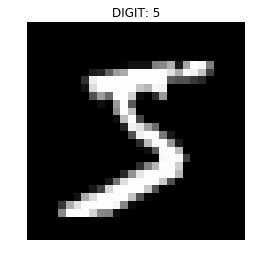

In [2]:
# MNIST Dataset (Images and Labels)
# If you have not mounted the dataset, you can download it
# just adding download=True as parameter
train_dataset = dsets.MNIST(root='/input', 
                            train=True, 
                            transform=transforms.ToTensor())
x_train_mnist, y_train_mnist = train_dataset.train_data.type(torch.FloatTensor), train_dataset.train_labels
test_dataset = dsets.MNIST(root='/input', 
                           train=False, 
                           transform=transforms.ToTensor())
x_test_mnist, y_test_mnist = test_dataset.test_data.type(torch.FloatTensor), test_dataset.test_labels

print('Training Data Size: ' ,x_train_mnist.size(), '-', y_train_mnist.size())
print('Testing Data Size: ' ,x_test_mnist.size(), '-', y_test_mnist.size())

plt.imshow(x_train_mnist[0].numpy(), cmap='gray')
plt.title('DIGIT: %i' % y_train_mnist[0])
plt.axis('off')
plt.show()

torch.utils.data.DataLoader combines a dataset and a sampler, and provides single or multi-process iterators over the dataset.

In [3]:
# Hyperparameter
batch_size = 8

# Training Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# Testing Dataset Loader (Input Pipline)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

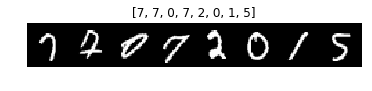

In [4]:
# Plot a grid of images
def imshow(inp_tensor, title):
    """image show for Tensor"""
    img = inp_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch
trainset_iter = iter(train_loader)
images, labels = trainset_iter.next()
# show images
batch_imgs = make_grid(images, nrow=batch_size)
plt.axis('off')
imshow(batch_imgs, title=[x for x in labels])

### Convolutional Neural Network

Convolutional neural networks are the current state-of-art architecture for image classification. They’re used in practice today in facial recognition, self driving cars, and detecting whether an object is a hot-dog.

#### Basic Architecture
The basics of a CNN architecture consist of 3 components. A convolution, pooling, and fully connected layer. These components work together to learn a dense feature representation of an input.

#### Convolution

![Conv visualization](https://cdn-images-1.medium.com/max/1600/1*1VJDP6qDY9-ExTuQVEOlVg.gif)

A convolution consists of a **kernel** *(green square above)*, also called filter, that is applied in a sliding window fashion to extract features from the input. This filter is shifted after each operation across the input by an amount called **strides**. At each operation, a matrix multiply of the kernel and current region of input is calculated. Filters can be stacked to create high-dimensional representations of the input.

```
What happens if the filter doesn’t evenly map to the size of the input ?
```

There are two ways of handling differing filter size and input size, known as **same** padding and **valid** padding. Same padding will pad the input border with zeros (as seen above) to ensure the input width and height are preserved. Valid padding does not pad.

Typically, you’ll want to use same padding or you’ll rapidly reduce the dimensionality of your input.

Finally, an activation function (typically a [ReLU](https://en.wikipedia.org/wiki/Rectifier_%28neural_networks%29)) is applied to give the convolution non-linearity. ReLU’s are a bit different from other activation functions, such as sigmoid or tanh, as ReLUs are one-sided. This one-sided property allows the network to create sparse representation (zero value for hidden units), increasing computational efficiency.

![ReLu](https://cdn-images-1.medium.com/max/1600/1*5dklg6CDKStDhmkL2SPfmA.png)

#### Pooling

Pooling is an operation to reduce dimensionality. It applies a function summarizing neighboring information. Two common functions are max pooling and average pooling. By calculating the max of an input region, the output summarizes intensity of surrounding values.

Pooling layers also have a kernel, padding and are moved in strides. To calculate the output size of a pooling operation, you can use the formula:

```
output_size = (Input Width - kernel width + 2 * padding) / strides + 1 
```

![Pool](https://cdn-images-1.medium.com/max/1600/1*Ixw2W_3ZPiaerKNOrEcXig.jpeg)

#### Fully Connected Layer

Fully connected layers you are likely familiar with from neural networks. Each neuron in the input is connected to each neuron in the output; fully-connected. Due to this connectivity, each neuron in the output will be used at most one time.

![fc](https://cdn-images-1.medium.com/max/1600/1*JnvYW8ehgC92BYY9v9ZXZg.gif)

In a CNN, the input is fed from the pooling layer into the fully connected layer. Depending on the task, a regression or classification algorithm can be applied to create the desired output.

#### Review

You’ve now learned about what makes up a convolutional neural network. By passing input through a convolution, you extract highly-dimensional features. Pooling summarizes spatial information and reduces dimensionality. Lastly, this feature representation is passed through fully connected layers to a classifier or regressor.

![mnist cnn model](https://github.com/floydhub/mnist/blob/master/images/mnist_convet.png?raw=true)

In [5]:
# Hyperparameter
batch_size = 64

# Training Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# Testing Dataset Loader (Input Pipline)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Build the Model

We have defined in great details Neural Network. In the next snippet of code we will translate everything in PyTorch code.

In [6]:
# Hyperparameters
input_size = 784 # 28 * 28
hidden_size = 500
num_classes = 10
learning_rate = 1e-3

#### Model ####
# Convolutional Neural Network Model
class CNN(nn.Module):
    """ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

    
    
model = CNN(num_classes)

# If you are running a GPU instance, load the model on GPU
if cuda:
    model.cuda()
    

#### Loss and Optimizer ####
# Softmax is internally computed.
loss_fn = nn.CrossEntropyLoss()
# If you are running a GPU instance, compute the loss on GPU
if cuda:
    loss_fn.cuda()
    
# Set parameters to be updated.  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

### Train
We will train our model for 5 epochs and evaluate on test set.

In [7]:
# Hyperparameters
num_epochs = 5
print_every = 100

# Metrics
train_loss = []
train_accu = []

# Model train mode
model.train()
# Training the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # image unrolling
        images = Variable(images)
        labels = Variable(labels)
        
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Load loss on CPU
        if cuda:
            loss.cpu()
        loss.backward()
        optimizer.step()
        
        ### Keep track of metric every batch
        # Loss Metric
        train_loss.append(loss.data[0])
        # Accuracy Metric
        prediction = outputs.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(labels.data).sum()/batch_size*100
        train_accu.append(accuracy)
        
        # Log
        if (i+1) % print_every == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f, Accuracy: %.4f' 
                   % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0], accuracy))

Epoch: [1/5], Step: [100/937], Loss: 0.7680, Accuracy: 73.4375
Epoch: [1/5], Step: [200/937], Loss: 0.4178, Accuracy: 84.3750
Epoch: [1/5], Step: [300/937], Loss: 0.4366, Accuracy: 84.3750
Epoch: [1/5], Step: [400/937], Loss: 0.5098, Accuracy: 85.9375
Epoch: [1/5], Step: [500/937], Loss: 0.3783, Accuracy: 87.5000
Epoch: [1/5], Step: [600/937], Loss: 0.2915, Accuracy: 90.6250
Epoch: [1/5], Step: [700/937], Loss: 0.3397, Accuracy: 92.1875
Epoch: [1/5], Step: [800/937], Loss: 0.4938, Accuracy: 87.5000
Epoch: [1/5], Step: [900/937], Loss: 0.1384, Accuracy: 92.1875
Epoch: [2/5], Step: [100/937], Loss: 0.2406, Accuracy: 93.7500
Epoch: [2/5], Step: [200/937], Loss: 0.2186, Accuracy: 95.3125
Epoch: [2/5], Step: [300/937], Loss: 0.3452, Accuracy: 90.6250
Epoch: [2/5], Step: [400/937], Loss: 0.2622, Accuracy: 89.0625
Epoch: [2/5], Step: [500/937], Loss: 0.4096, Accuracy: 92.1875
Epoch: [2/5], Step: [600/937], Loss: 0.2443, Accuracy: 93.7500
Epoch: [2/5], Step: [700/937], Loss: 0.1874, Accuracy: 

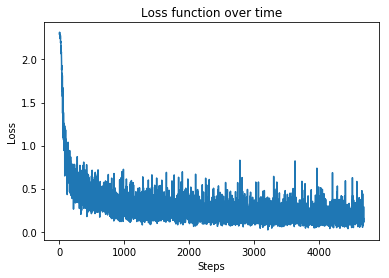

In [8]:
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss function over time")
plt.plot(np.arange(len(train_loss)), train_loss)

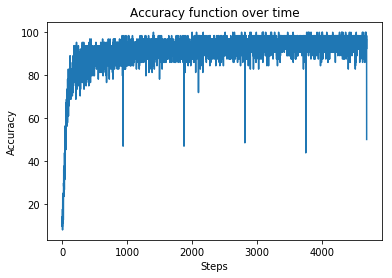

In [9]:
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy function over time")
plt.plot(np.arange(len(train_accu)), train_accu)

### Evaluate
Let's evaluate our model on test set.

In [10]:
model.eval()
correct = 0
for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    if cuda:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    # Load output on CPU
    if cuda:
        output.cpu()
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('\nTest set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))


Test set: Accuracy: 98.18%


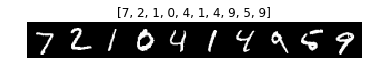

In [11]:
# Test Label

# Hyperparameter
batch_size = 10

# Testing Dataset Loader (Input Pipline)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Plot a grid of images
def imshow(inp_tensor, title):
    """image show for Tensor"""
    img = inp_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch
testset_iter = iter(test_loader)
images, labels = testset_iter.next()
# show images
batch_imgs = make_grid(images, nrow=batch_size)
plt.axis('off')
imshow(batch_imgs, title=[x for x in labels])

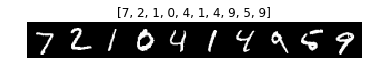

In [12]:
# Result from Training

input = Variable(images, volatile=True)
if cuda:
    input = input.cuda()
output = model(input)
# Load output on CPU
if cuda:
    output.cpu()
    
plt.axis('off')
imshow(batch_imgs, title=[x for x in output.data.max(1)[1]])

### Is it possible to do better?

Yes, the best score reported on this task is around [0.999...%](https://www.kaggle.com/c/digit-recognizer/leaderboard) without any form of data agumentation, only tuning the model. (Do not consider the 1.0 that is cheating)

### Summary

TODO

### It's you turn!

Play a bit with different with CNN model adding more Conv Layer, Batch/Layer Norm, Dropout, Residual Connection, different optimizers(try YellowFin a recent optimizers), replace Relu with Swish(a new activation function). There are too many things to try! Otherwise are you reading to learn how to manage sequence? We are waiting for you in the next episode: Sequence Models.

### Thanks and Resources

[Cole Murray - Deep Learning CNN’s in Tensorflow with GPUs](https://hackernoon.com/deep-learning-cnns-in-tensorflow-with-gpus-cba6efe0acc2)